Drawbacks of the bigram model are that if we take another character for context, the dimensions of the grid we create grows exponentially. Thus, we are now going to create a **Multi-layer Perceptron** using the following research paper to model our character level language model: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf.


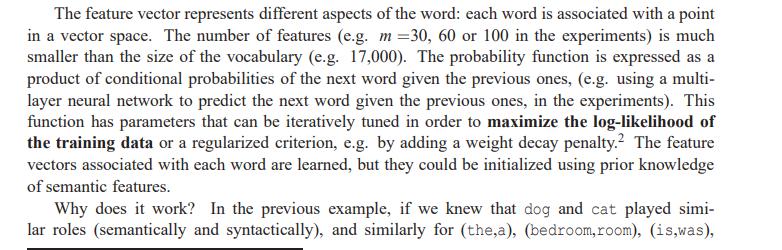

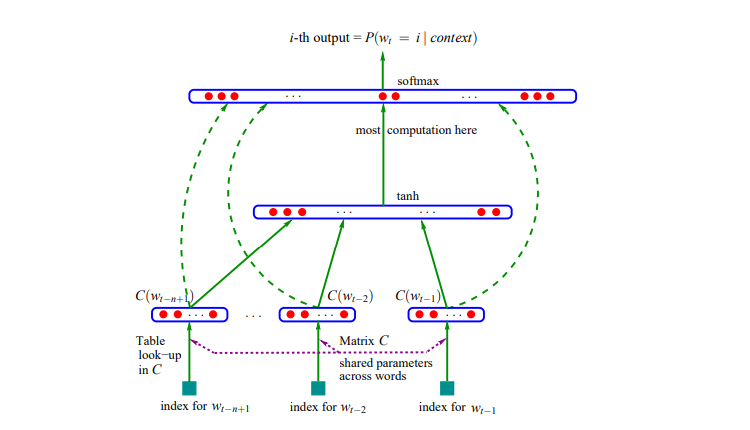


(Misc) 
Vocab
- Out of Distribution: instances that do not belong to the distribution the classifier has been trained on
- Embeddings- a type of hidden layer in a neural network

Description of diagram:

Out of 17000 vocabulary of words, it takes in the indices of 3 words in the list of 17000 words(0-16999). Then, through a look up table C (that is lets say 17000 X N neurons), we can get the specific embedding in N-dimensional space corresponding to the specific word. Next, the hidden layer of the Neural Network is a hyperparameter (varying size) which would be fully connected to the 3N neurons that make up the 3 inputs. Then tanh activiation. Then, the output layer has 17000 Neurons which are fully connected to the hidden layer. Lastly, there is softmax layer on top of the output layer so that there is a nice probability distribution for the next word in the sequence.

In [209]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [210]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [211]:
len(words)

32033

In [212]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [213]:
# build the dataset
def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], [] # X-inputs to nn, Y-labels to each 
    for w in words:
        
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9* len(words))

# training split; dev/validation split; test split
# 80%; 10%; 10%
# train parameters; train hyperparameters; evaluate performance of model

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
    

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [214]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [247]:
g = torch.Generator().manual_seed(2147483647) # reproducibility

# 27 characters in 10 dimensional space for lookup table C
C = torch.randn((27, 10), generator=g) 

# weights and bias for hidden layer
# 10 dimensional space with 3 inputs = (10*3) = 30; 200 neurons hyperparameter
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)

# weights and bias for output layer 
# (takes in 200 neurons, outputs 27 (# of chars))
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

In [248]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [249]:
for p in parameters:
    p.requires_grad = True

In [250]:
# learning rate exponent
lre = torch.linspace(-3, 0, 1000)
# learning rates
lrs = 10**lre

In [255]:
# learning rate exponent with corresponding loss can be graphed to find ideal lr
lri = []
lossi = []
stepi = []

In [265]:
for i in range(200000):
    
    '''minibatch construct- we only get 32 rows of X for embedded layer'''
    # much faster but less reliable gradient direction
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    '''forward pass'''
    # hidden layer h with embedded layers (of 3 inputs)
    emb = C[Xtr[ix]] # (32, 3, 2) [not ('large number', 3, 2) due to minibatch]
    # tensor.view is very efficient- check this: http://blog.ezyang.com/2019/05/pytorch-internals
    h = torch.tanh(emb.view(emb.shape[0], 30) @ W1 + b1) # (32, 100)
    # output layer
    logits = h @ W2 + b2 # (32, 27)
    # calculates loss more efficiently
    # https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html
    loss = F.cross_entropy(logits, Ytr[ix])

    '''backward pass'''
    for p in parameters:
        p.grad = None
    loss.backward()

    '''update'''
    # lr = lrs[i]
    lr = 0.01 if i < 100000 else 0.01 # ideal learning rate- eventually do training rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track states
#     lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

2.0128254890441895


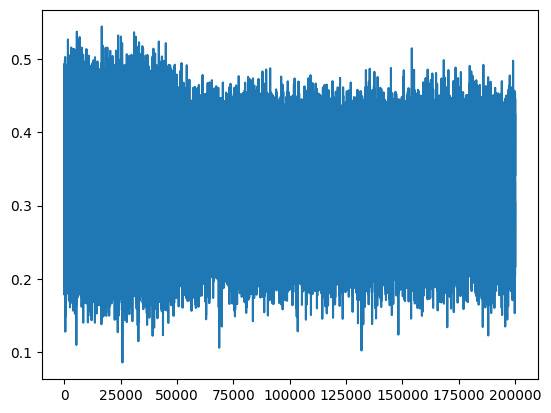

In [266]:
plt.plot(stepi, lossi)

In [267]:
# now using train split to evaluate loss
emb = C[Xtr] 
h = torch.tanh(emb.view(emb.shape[0], 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1097, grad_fn=<NllLossBackward0>)

In [268]:
# now using dev split to evaluate loss
emb = C[Xdev] 
h = torch.tanh(emb.view(emb.shape[0], 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1592, grad_fn=<NllLossBackward0>)

Quite a few knobs available to make the loss for our dev split even lower. We can change the number of neurons in the hidden layer of the model. We can change the dimensionality of the embedding look up table. We can change the number of characters feeding as context into this neural net. Of course we can also change the details of the optimization: how long are we running, what is the learning rate, how does it decay over time, and changing the batch size.

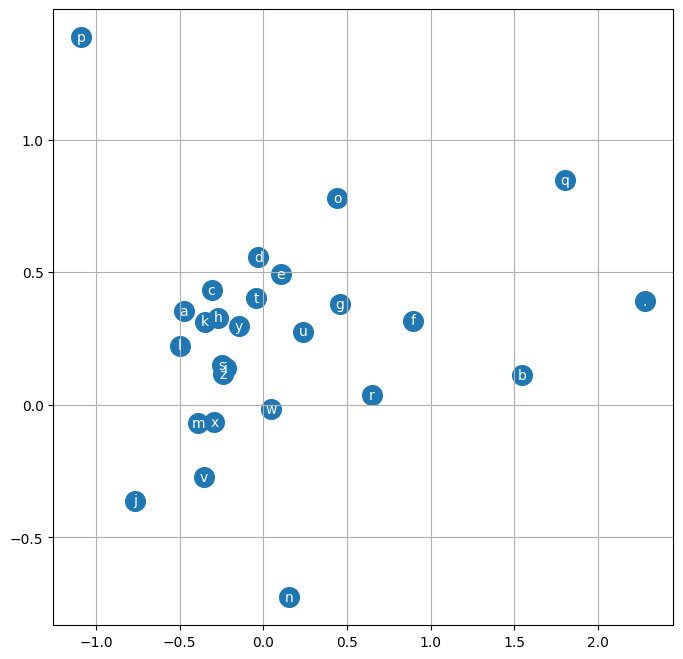

In [270]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')   

In [269]:
# sample from the model
g = torch.Generator().manual_seed(1)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ... (dots)
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d) (dim = 1 because single word generated)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1) # hidden state
        logits = h @ W2 + b2 # output layer
        probs = F.softmax(logits, dim=1) # softmax exponentiates logits and makes them sum to 1
        ix = torch.multinomial(probs, num_samples=1, generator=g).item() # sample from probs
        context = context[1:] + [ix] # shift context window
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

hider.
stena.
cole.
wila.
bran.
aalea.
joli.
rambreckleya.
endiaraleighan.
vicrushal.
amme.
karo.
sivo.
kenlanderrylan.
milanna.
mee.
mara.
chasamnaudalmana.
asmin.
yayna.


These names seem pretty good!